In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # data visualization library  
from functools import reduce
import xgboost

path = "../NCAA-2018-Prediction/Data Files"
import os
print(os.listdir(path))

['SampleSubmissionStage2.csv', 'SampleSubmissionStage1.csv', '.DS_Store', 'Teams.csv', 'TeamConferences.csv', 'NCAATourneySeeds.csv', 'SecondaryTourneyTeams.csv', 'NCAATourneySeedRoundSlots.csv', 'RegularSeasonDetailedResults.csv', 'RegularSeasonCompactResults.csv', 'TeamCoaches.csv', 'Cities.csv', 'SecondaryTourneyCompactResults.csv', 'GameCities.csv', 'TeamSpellings.csv', 'Seasons.csv', 'MasseyOrdinals.csv', 'ConferenceTourneyGames.csv', 'Conferences.csv', 'NCAATourneySlots.csv', 'NCAATourneyCompactResults.csv', 'NCAATourneyDetailedResults.csv']


In [3]:
# load data
NCAATourneySeeds = pd.read_csv(path + '/NCAATourneySeeds.csv')
NCAATourneyDetailedResults = pd.read_csv(path + '/NCAATourneyDetailedResults.csv')
RegularSeasonCompactResults = pd.read_csv(path + '/RegularSeasonCompactResults.csv')
RegularSeasonDetailedResults = pd.read_csv(path + '/RegularSeasonDetailedResults.csv')
Teams = pd.read_csv(path + '/Teams.csv')
Seasons = pd.read_csv(path + '/Seasons.csv')
MasseyOrdinals = pd.read_csv(path + '/MasseyOrdinals.csv')
SampleSubmissionStage1 = pd.read_csv(path + '/SampleSubmissionStage1.csv')
ordinal = pd.read_csv(path + '/MasseyOrdinals.csv')

## Add feature

In [4]:
# Average ranking of each team before NCAA March Madness each year
ordinal_rank = pd.DataFrame({'Avgrank' : ordinal[ordinal['RankingDayNum'] == 133].groupby(['Season','TeamID'])['OrdinalRank'].mean()}).reset_index()

In [5]:
def add_feature(inputdf):
    outdf = inputdf.copy()
    outdf['WFGpct'] = outdf['WFGM']/outdf['WFGA']
    outdf['LFGpct'] = outdf['LFGM']/outdf['LFGA']
    outdf['WFGpct3'] = outdf['WFGM3']/outdf['WFGA3']
    outdf['LFGpct3'] = outdf['LFGM3']/outdf['LFGA3']
    outdf['WDefRtg'] = 100 * outdf['LScore']/(outdf['LFGA'] + 0.475 * outdf['LFTA'] - outdf['LOR'] + outdf['LTO'])
    outdf['LDefRtg'] = 100 * outdf['WScore']/(outdf['WFGA'] + 0.475 * outdf['WFTA'] - outdf['WOR'] + outdf['WTO'])
    outdf['WAT'] = outdf['WAst']/outdf['WTO']
    outdf['LAT'] = outdf['LAst']/outdf['LTO']
    outdf[np.isinf(outdf['LAT']) == True] = None
    outdf['Part1'] = outdf['WFGA'] + 0.4* outdf['WFTA'] - 1.07 * (outdf['WOR']/(outdf['WOR'] + outdf['LDR'])) * (outdf['WFGA'] - outdf['WFGM']) + outdf['WTO']
    outdf['Part2'] = outdf['LFGA'] + 0.4* outdf['LFTA'] - 1.07 * (outdf['LOR']/(outdf['LOR'] + outdf['WDR'])) * (outdf['LFGA'] - outdf['LFGM']) + outdf['LTO']
    outdf['WOffRtg'] = 100 * outdf['WScore'] / (0.5* (outdf['Part1'] + outdf['Part2']))
    outdf = outdf.drop(['Part1','Part2'],axis=1)
    outdf['Part1'] = outdf['LFGA'] + 0.4* outdf['LFTA'] - 1.07 * (outdf['LOR']/(outdf['LOR'] + outdf['WDR'])) * (outdf['LFGA'] - outdf['LFGM']) + outdf['LTO']
    outdf['Part2'] = outdf['WFGA'] + 0.4* outdf['WFTA'] - 1.07 * (outdf['WOR']/(outdf['WOR'] + outdf['LDR'])) * (outdf['WFGA'] - outdf['WFGM']) + outdf['WTO']
    outdf['LOffRtg'] = 100 * outdf['LScore'] / (0.5* (outdf['Part1'] + outdf['Part2']))
    outdf = outdf.drop(['Part1','Part2'],axis=1)
    outdf = outdf[np.isfinite(outdf['Season'])]
    return outdf

In [6]:
# Each team, Compute Avg of all features by year
def stat_table(inputdf, var):
    df = inputdf
    df['W'] = df['W' + var]
    df['L'] = df['L' + var]

    W = df.groupby(['Season','WTeamID'])['W'].agg(['sum','count'])
    W = W.reset_index().rename(columns={'sum':'Wsum','count':'Wcount','WTeamID':'TeamID'})
    L = df.groupby(['Season','LTeamID'])['L'].agg(['sum','count'])
    L = L.reset_index().rename(columns={'sum':'Lsum','count':'Lcount','LTeamID':'TeamID'})
    stat = pd.merge(W,L,left_on=['Season','TeamID'],right_on=['Season','TeamID'],how='inner')
    stat['sum'] = stat['Wsum'] + stat['Lsum']
    stat['count'] = stat['Wcount'] + stat['Lcount']
    stat['Avg'+var] = stat['sum']/stat['count']
    stat = stat[['Season','TeamID','Avg'+var]]
    return stat

# Calculate the difference of each stat between winner and loser
def add_diff(inputdf, statdf, var):
    if (var != 'seed_int'):
        df = inputdf.merge(statdf[['Season','TeamID','Avg'+var]],left_on=['Season','WTeamID'],right_on=['Season','TeamID'],how='left')
        df2 = df.drop('TeamID',axis=1).rename(columns={'Avg'+var:'WAvg'+var})
        df3 = df2.merge(statdf[['Season','TeamID','Avg'+var]],left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
        outputdf = df3.drop('TeamID',axis=1).rename(columns={'Avg'+var:'LAvg'+var})
        outputdf['Diff'+var] = outputdf['WAvg'+var] - outputdf['LAvg'+var]
        outputdf = outputdf.drop(['WAvg'+var,'LAvg'+var], axis = 1)
    else:
        df = inputdf.merge(statdf[['Season','TeamID',var]],left_on=['Season','WTeamID'],right_on=['Season','TeamID'],how='left')
        df2 = df.drop('TeamID',axis=1).rename(columns={var:'W'+var})
        df3 = df2.merge(statdf[['Season','TeamID',var]],left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
        outputdf = df3.drop('TeamID',axis=1).rename(columns={var:'L'+var})
        outputdf['Diff'+var] = outputdf['W'+var] - outputdf['L'+var]
        outputdf = outputdf.drop(['W'+var,'L'+var], axis = 1)
    return outputdf

## Add features to stat_final df

In [7]:
df = pd.concat([RegularSeasonDetailedResults, NCAATourneyDetailedResults])
finaldf = add_feature(inputdf = df)
finaldf['target'] = 1
ast = stat_table(finaldf, var = 'Ast')
to = stat_table(finaldf, var = 'TO')
fga = stat_table(finaldf, var = 'FGA')
fga3 = stat_table(finaldf, var = 'FGA3')
fgpct = stat_table(finaldf, var = 'FGpct')
fgpct3 = stat_table(finaldf, var = 'FGpct3')
at = stat_table(finaldf, var = 'AT')
offreb = stat_table(finaldf, var = 'OR')
defreb = stat_table(finaldf, var = 'DR')
offrtg = stat_table(finaldf, var = 'OffRtg')
defrtg = stat_table(finaldf, var = 'DefRtg')
dfs = [ast,to,fga,fga3,fgpct,fgpct3,at,offreb,defreb,offrtg,defrtg]
stat_final = reduce(lambda left,right: pd.merge(left,right,on=['Season','TeamID']), dfs)

In [8]:
stat_final.head()

,Season,TeamID,AvgAst,AvgTO,AvgFGA,AvgFGA3,AvgFGpct,AvgFGpct3,AvgAT,AvgOR,AvgDR,AvgOffRtg,AvgDefRtg
0,2003.0,1102.0,13.000000,11.428571,39.785714,20.821429,0.486149,0.367637,1.375064,4.178571,16.821429,105.695751,103.815398
1,2003.0,1103.0,15.222222,12.629630,55.851852,16.074074,0.487294,0.331990,1.324485,9.777778,19.925926,113.112726,110.627622
2,2003.0,1104.0,12.137931,13.103448,57.000000,19.586207,0.419794,0.328588,1.014204,13.413793,23.793103,105.732100,98.773850
3,2003.0,1105.0,14.538462,18.653846,61.615385,20.769231,0.396204,0.359630,0.861957,13.500000,23.115385,95.209429,100.981886
4,2003.0,1106.0,11.678571,17.035714,55.285714,17.642857,0.425530,0.350196,0.723189,12.285714,23.857143,95.315266,94.460182


In [9]:
# Create seed feature
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds = NCAATourneySeeds.copy()
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [10]:
# Add seed_int to stat_final df
stat_final = stat_final.merge(df_seeds, left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
stat_final['seed_int'].fillna(0,inplace=True)
stat_final = stat_final.merge(ordinal_rank, left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
stat_final['Avgrank'].fillna(0,inplace=True)

In [11]:
# Add AvgDiff to final df
finaldf = add_diff(finaldf, stat_final, 'Ast')
finaldf = add_diff(finaldf, stat_final, 'TO')
finaldf = add_diff(finaldf, stat_final, 'FGA')
finaldf = add_diff(finaldf, stat_final, 'FGA3')
finaldf = add_diff(finaldf, stat_final, 'FGpct')
finaldf = add_diff(finaldf, stat_final, 'FGpct3')
finaldf = add_diff(finaldf, stat_final, 'AT')
finaldf = add_diff(finaldf, stat_final, 'OR')
finaldf = add_diff(finaldf, stat_final, 'DR')
finaldf = add_diff(finaldf, stat_final, 'OffRtg')
finaldf = add_diff(finaldf, stat_final, 'DefRtg')
finaldf = add_diff(finaldf, stat_final, 'seed_int')
finaldf = add_diff(finaldf, stat_final, 'rank')
finaldf = finaldf.drop(['W','L'], axis = 1)

In [12]:
# Drop N/A
finaldf = finaldf.dropna(how='any')

In [18]:
print('Regular Season records', finaldf[finaldf['DayNum'] < 136]['Season'].count())
print('NCAA Season records', finaldf[finaldf['DayNum'] >= 136]['Season'].count())

Regular Season records 81936
NCAA Season records 945


In [19]:
# Add weight variable, put more weight to NCAA data by setting at 100.
# This is an arbitrary number just to make NCAA season equally important with the regular season.
finaldf['weight'] = 1
finaldf.loc[finaldf[finaldf['DayNum'] >= 136].index,'weight'] = 100

In [31]:
# Variable Analysis, keep only necessary variables
train_data = finaldf[['target','weight'
                      ,'WLoc','Diffrank'
                      ,'DiffAst','DiffTO'
                      ,'DiffFGpct3'
                      ,'DiffFGA','DiffFGA3'
                      ,'DiffOffRtg','DiffDefRtg']]

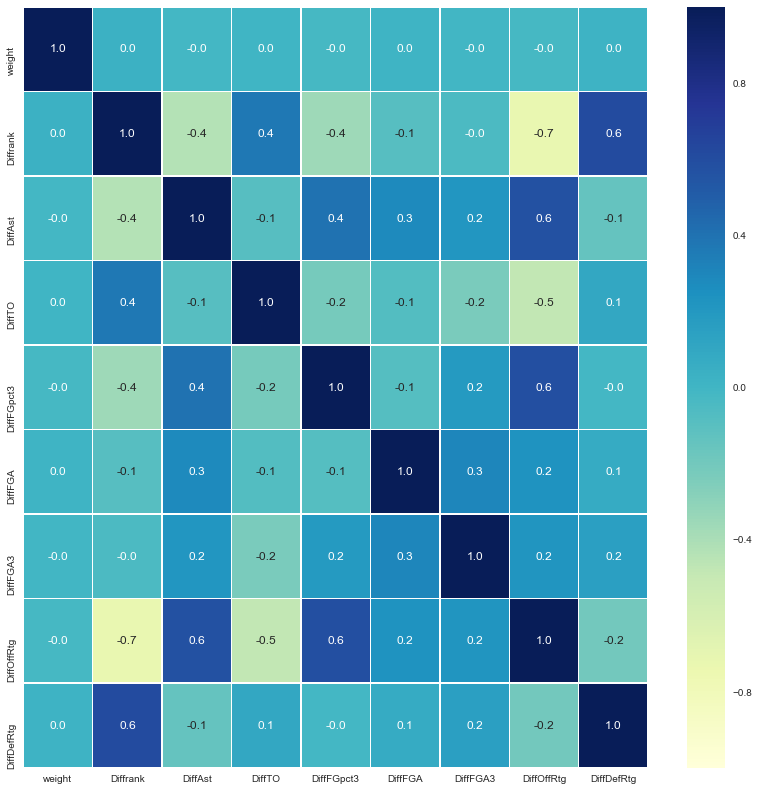

In [32]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(train_data.loc[:, train_data.columns != 'target'].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax , cmap="YlGnBu")

In [22]:
# Target variable are all equal to 1. Half of them needs to change to 0
# Have to flip the sign of most features.
# Swap location from Home(H) to Away(A).
train0= train_data.sample(frac=0.5,random_state=200)
train1= train_data.drop(train0.index)
train0_X = train0.loc[:, ~train0.columns.isin(['target','weight'])]
train0_X_num = train0_X.loc[:, train0_X.columns != 'WLoc']
train0_X_cat = train0_X.loc[:, train0_X.columns == 'WLoc']
train0_w = train0.loc[:, train0.columns == 'weight']
train0_y = train0.loc[:, train0.columns == 'target']

In [23]:
train0_X_num = train0_X_num.apply(lambda x: x*-1)
train0_X_cat = train0_X_cat.replace('A','X')
train0_X_cat = train0_X_cat.replace('H','A')
train0_X_cat = train0_X_cat.replace('X','H')
train0_y = train0_y.apply(lambda x: x*0)

In [24]:
train0_X = pd.concat([train0_X_cat, train0_X_num], axis = 1)
train0 = pd.concat([train0_y, train0_w, train0_X], axis = 1)
train_data = pd.concat([train0, train1], axis = 0)

train_data = pd.get_dummies(train_data)
train_data.rename(columns={'WLoc_A':'Loc_A','WLoc_H':'Loc_H','WLoc_N':'Loc_N'},inplace=True)
train_data.drop(['Loc_N'], axis = 1, inplace= True)

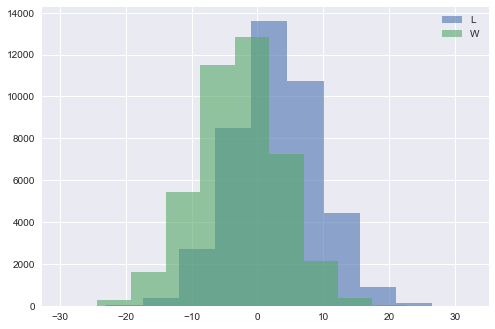

In [25]:
# Visualize predictive power of each feature
def plot_hist(var):
    df_graph = train_data[[var,'target']]
    plt.hist(df_graph[df_graph["target"]== 0][var].reset_index(drop=True), alpha=0.6, label="L")
    plt.hist(df_graph[df_graph["target"]==1][var].reset_index(drop=True), alpha=0.6, label="W")
    plt.legend()
    plt.show()
plot_hist('DiffDefRtg')

In [26]:
X = train_data.iloc[:, 2:]
w = train_data.iloc[:, 1]
y = train_data.iloc[:, 0]

In [27]:
# Split train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size = 0.2, random_state = 0)

In [78]:
# Variable Selection
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(X_train,y_train)
importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.331119)
2. feature 7 (0.117450)
3. feature 6 (0.112993)
4. feature 1 (0.078397)
5. feature 2 (0.075693)
6. feature 3 (0.074651)
7. feature 4 (0.073728)
8. feature 5 (0.073651)
9. feature 9 (0.038332)
10. feature 8 (0.023986)


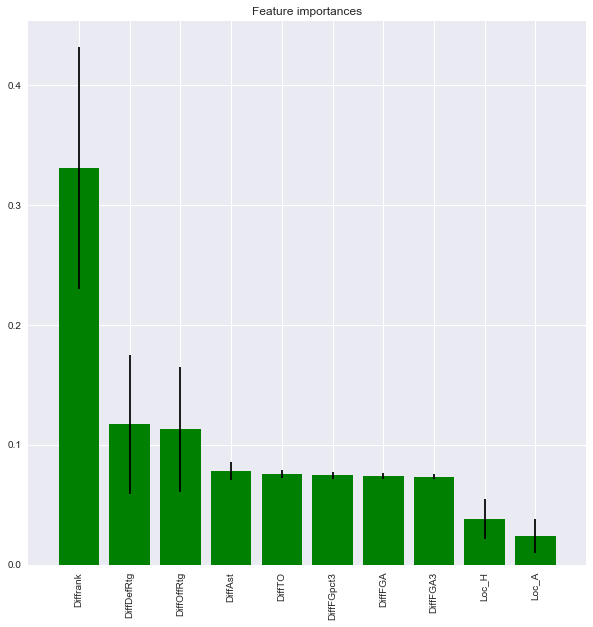

In [79]:
# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [34]:
# Use RFE to select most important features.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

clf_rf = RandomForestClassifier() 
rfe = RFE(estimator=clf_rf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

# Use RFECV to choose optimal number of features
from sklearn.feature_selection import RFECV

clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Chosen best 5 feature by rfe: Index(['Diffrank', 'DiffAst', 'DiffFGpct3', 'DiffOffRtg', 'DiffDefRtg'], dtype='object')
Optimal number of features : 10
Best features : Index(['Diffrank', 'DiffAst', 'DiffTO', 'DiffFGpct3', 'DiffFGA', 'DiffFGA3',
       'DiffOffRtg', 'DiffDefRtg', 'Loc_A', 'Loc_H'],
      dtype='object')


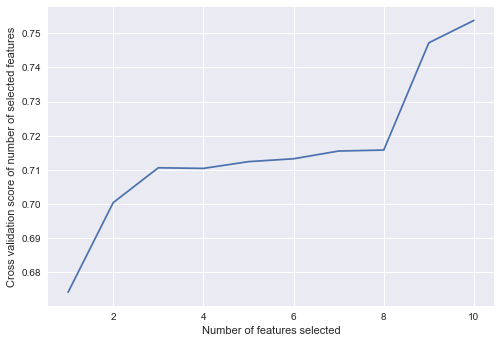

In [35]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [42]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train, sample_weight=w_train)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print('Mean : ' , accuracies.mean())
print('Std : ' , accuracies.std())

from sklearn.model_selection import GridSearchCV
parameters={
    'max_depth': [2], #[3,4,5,6,7,8,9],
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('best accuracy :', best_accuracy)
print('best parameters :', best_parameters)

Mean :  0.779394816849
Std :  0.00397984149807
best accuracy : 0.777449324324
best parameters : {'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 0.03, 'subsample': 0.6}


In [43]:
#Probability output for logistic regression
prob_pred = classifier.predict_proba(X_test)[:,1]
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('cm : ', cm)
print('Accuracy : ', (cm[0][0]+cm[1][1])/cm.sum())

cm :  [[6294 1864]
 [2022 6397]]
Accuracy :  0.765578814019


In [44]:
# Check result on NCAA
NCAA_data = finaldf[['target','DayNum'
                      ,'WLoc','Diffrank'
                      ,'DiffAst','DiffTO'
                     ,'DiffFGpct3'
                      ,'DiffFGA','DiffFGA3'
                      ,'DiffOffRtg','DiffDefRtg'
                     ]]
NCAA_data = NCAA_data[NCAA_data['DayNum'] >= 136]
NCAA_data.drop(['DayNum'], axis = 1, inplace=True)
NCAA_data = pd.get_dummies(NCAA_data)
NCAA_data.rename(columns={'WLoc_N':'Loc_N'},inplace=True)
NCAA_data['Loc_A'] = 0
NCAA_data['Loc_H'] = 0
NCAA_data.drop(['Loc_N'], axis = 1 , inplace = True)

X_NCAA = NCAA_data.iloc[:, 1:]
y_NCAA = NCAA_data.iloc[:, 0]

In [45]:
y_pred_NCAA = classifier.predict(X_NCAA)
cm = confusion_matrix(y_NCAA, y_pred_NCAA)
print(cm)
print('Accuracy : ', (cm[0][0]+cm[1][1])/cm.sum())

[[  0   0]
 [259 686]]
Accuracy :  0.725925925926


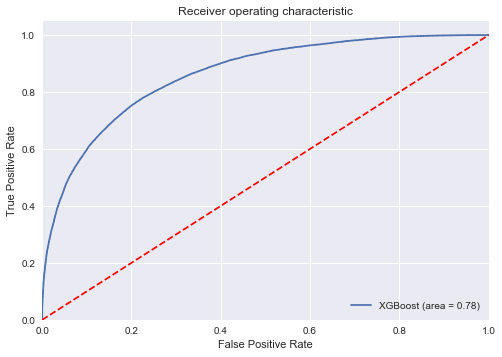

In [51]:
# ROC for all training data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y_train, classifier.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, classifier.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [52]:
# Confusion matrix for all data
y_pred_all = classifier.predict(X)
cm = confusion_matrix(y, y_pred_all)
cm

array([[32282,  9158],
       [ 9515, 31926]])

In [53]:
# Create submission file
SampleSubmissionStage2 = pd.read_csv(path + '/SampleSubmissionStage2.csv')
Matchup = SampleSubmissionStage2.copy()
Matchup[['Season', 'WTeamID', 'LTeamID']] = Matchup['ID'].str.split("_", expand=True)
Matchup.drop(['Pred'], axis = 1, inplace=True)
Matchup['Season'] = Matchup['Season'].astype(int)
Matchup['WTeamID'] = Matchup['WTeamID'].astype(int)
Matchup['LTeamID'] = Matchup['LTeamID'].astype(int)

In [54]:
Matchup = add_diff(Matchup, stat_final, 'Ast')
Matchup = add_diff(Matchup, stat_final, 'TO')
Matchup = add_diff(Matchup, stat_final, 'FGA')
Matchup = add_diff(Matchup, stat_final, 'FGA3')
Matchup = add_diff(Matchup, stat_final, 'FGpct')
Matchup = add_diff(Matchup, stat_final, 'FGpct3')
Matchup = add_diff(Matchup, stat_final, 'AT')
Matchup = add_diff(Matchup, stat_final, 'OR')
Matchup = add_diff(Matchup, stat_final, 'DR')
Matchup = add_diff(Matchup, stat_final, 'OffRtg')
Matchup = add_diff(Matchup, stat_final, 'DefRtg')
Matchup = add_diff(Matchup, stat_final, 'seed_int')
Matchup = add_diff(Matchup, stat_final, 'rank')
Matchup.rename(columns={'WTeamID':'TeamID1','LTeamID':'TeamID2'}, inplace=True)

In [56]:
Matchup_data = Matchup.loc[:,X_train.drop(['Loc_A','Loc_H'], axis = 1).columns]
Matchup_data['Loc_A'] = 0
Matchup_data['Loc_H'] = 0
X_matchup = Matchup_data

In [57]:
#Output Probability
prob_pred_matchup = classifier.predict_proba(X_matchup)[:,1]
y_pred_matchup = classifier.predict(X_matchup)

In [58]:
pred = pd.DataFrame(data=prob_pred_matchup,columns=['pred'])
result = pd.concat([Matchup,pred], axis=1)
result = result.rename(columns={'ID':'id'})

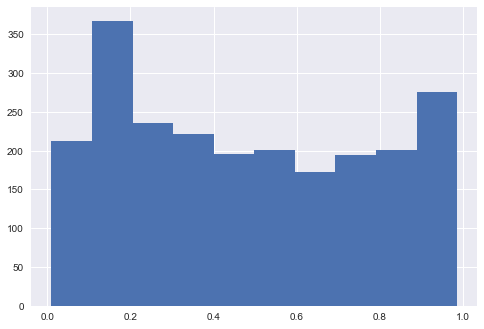

In [59]:
# Check histogram
result['pred'].hist()

In [60]:
# Keep it in the range between 0.05 - 0.95
result['pred'] = result['pred'].clip(0.05,0.95)

In [61]:
submit = result[['id','pred']]
submit.to_csv("NCAA_2018_v1.csv", index=False)

In [63]:
# Add Team Name instead of Team ID to check results
result_team = result[['TeamID1','TeamID2','pred']]
result_team1 = result_team.merge(Teams[['TeamID','TeamName']],left_on=['TeamID1'],right_on=['TeamID'],how='left')
result_team1.rename(columns={'TeamName':'Team1'}, inplace = True)
result_team2 = result_team1.merge(Teams[['TeamID','TeamName']],left_on=['TeamID2'],right_on=['TeamID'],how='left')
result_team2.rename(columns={'TeamName':'Team2'}, inplace = True)
result_team2.drop(['TeamID1','TeamID2','TeamID_x','TeamID_y'], axis = 1, inplace = True)

In [64]:
result_team2.head()

,pred,Team1,Team2
0,0.175383,Alabama,Arizona
1,0.373395,Alabama,Arizona St
2,0.282920,Alabama,Arkansas
3,0.227434,Alabama,Auburn
4,0.661610,Alabama,Bucknell
